## Importing Libararies

In [4]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers  import SGD, RMSprop, Adam as adam

from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import random as rn
from numpy import *
from tqdm import tqdm
import inspect
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import LeakyReLU
import datetime
import os
import keras
import pickle
import lzma
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Conv2D,MaxPooling2D,GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout

from tensorflow.keras import backend
backend.set_image_data_format('channels_last')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Reading Data

In [8]:
source_data = pd.read_csv("../train_data_all.csv")

In [9]:
source_data["path"] = "../"+source_data["path"]

In [10]:
sources = source_data["source"].unique()
sources

array(['IEMOCAP', 'EMODB', 'SAVEE', 'RAVDESS'], dtype=object)

## Test Train Split

In [12]:
def get_train_test_data(source_data, eval_dataset,test_size=0.20, shape=(75,75)):
    
    data = source_data[(source_data.source==eval_dataset) & (source_data.augmented==0)]
    awgn_data = source_data[(source_data.source==eval_dataset) & (source_data.augmented!=0)]

    data = data [["path","emotion_class"]]
    awgn_data = awgn_data [["path","emotion_class"]]


    train_data, test_data = train_test_split(data,stratify=data['emotion_class'], 
                                                        test_size=test_size)

    train_data = pd.concat([train_data,awgn_data]).reset_index(drop=True)

    min_size = train_data.groupby("emotion_class").count()["path"].min()

    train_combined_data=[]
    for em in train_data["emotion_class"].unique():
        emotion_data = train_data[train_data["emotion_class"]==em]
        if len(emotion_data)>min_size:
            train_combined_data.append(emotion_data.sample(min_size))
        else:
            train_combined_data.append(emotion_data)

    image_train_data = create_train_data(train_data,shape)
    image_test_data = create_test_data(test_data,shape)


    X_train = np.array([i[0] for i in image_train_data])
    y_train = np.array([i[1] for i in image_train_data])
    X_test = np.array([i[0] for i in image_test_data])
    y_test = np.array([i[1] for i in image_test_data])


    return X_train,y_train,X_test,y_test

In [13]:
from tensorflow.keras.optimizers  import  RMSprop 

In [14]:
import os
import cv2
import random as rn
from numpy import *
from tqdm import tqdm
from sklearn.utils import shuffle

In [15]:
# Mean Normalization
def mean_normalization(image):
    return cv2.normalize(image, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

In [16]:
def create_train_data(train_df,shape):
    # Creating an empty list where we should store the training data
    # after a little preprocessing of the data
    training_data = []
  
    # tqdm is only used for interactive loading
    # loading the training data
    for row in train_df.itertuples():
  
        # labeling the images
        label = row.emotion_class
  
        path = row.path
  
        # loading the image from the path and then converting them into
        # grayscale for easier covnet prob
        img = cv2.imread(path)
        # print(img.shape)  
        # resizing the image for processing them in the covnet
        img = cv2.resize(img, shape)
        # print(img.shape)  
        img  = mean_normalization(img)
        # print(img.shape)  
        # final step-forming the training data list with numpy array of the images
        training_data.append([np.array(img),np.array(label)])
  
    # shuffling of the training data to preserve the random state of our data
    shuffle(training_data)
    return training_data

In [17]:
def create_test_data(test_df,shape):
    testing_data = []
    for row in test_df.itertuples():
        # labeling the images
        label = row.emotion_class
  
        path = row.path    
    
        img = cv2.imread(path)
        img = cv2.resize(img, shape)
        img  = mean_normalization(img)
        testing_data.append([np.array(img), np.array(label)])
          
    shuffle(testing_data)
    
#     savez_compressed(f'test_data/numpy_data/{dataset}_test_data.npz', testing_data, allow_pickle=True)
    return testing_data

In [18]:
def get_pre_trained_models():
    # List all available models
    model_dictionary = {m[0]:m[1] for m in inspect.getmembers(tf.keras.applications, inspect.isfunction)}
    model_list =['DenseNet169',
    'DenseNet121',
    'MobileNetV2',
    'Xception',
    'DenseNet201',
    'VGG16',
    'VGG19',
    'ResNet50V2',
    'ResNet152V2',
    'MobileNet',
    'InceptionV3']
    models_not_used = set(model_dictionary.keys())-set(model_list)
    
    for model_name in models_not_used:
        if model_name in model_dictionary:
            del model_dictionary[model_name]

    return model_dictionary

In [19]:
model_benchmarks_map ={}
model_dictionary = get_pre_trained_models()
model_dictionary

{'DenseNet121': <function tensorflow.python.keras.applications.keras_modules_injection.<locals>.wrapper(*args, **kwargs)>,
 'DenseNet169': <function tensorflow.python.keras.applications.keras_modules_injection.<locals>.wrapper(*args, **kwargs)>,
 'DenseNet201': <function tensorflow.python.keras.applications.keras_modules_injection.<locals>.wrapper(*args, **kwargs)>,
 'InceptionV3': <function tensorflow.python.keras.applications.keras_modules_injection.<locals>.wrapper(*args, **kwargs)>,
 'MobileNet': <function tensorflow.python.keras.applications.keras_modules_injection.<locals>.wrapper(*args, **kwargs)>,
 'MobileNetV2': <function tensorflow.python.keras.applications.keras_modules_injection.<locals>.wrapper(*args, **kwargs)>,
 'ResNet152V2': <function tensorflow.python.keras.applications.keras_modules_injection.<locals>.wrapper(*args, **kwargs)>,
 'ResNet50V2': <function tensorflow.python.keras.applications.keras_modules_injection.<locals>.wrapper(*args, **kwargs)>,
 'VGG16': <function

In [20]:
def train_pre_trained_models(dataset,X_train,y_train,X_test,y_test,input_shape=(75,75,3)):
    
    global model_benchmarks_map
    model_benchmarks = {'model_name': [], 'num_model_params': [],'validation_accuracy': []}
    
    for model_name, pre_train_model in tqdm(model_dictionary.items()):
        
        # load the pre-trained model with global average pooling as the last layer and freeze the model weights
        base_model = pre_train_model(weights='imagenet', include_top=False,input_shape=input_shape)
        # add a global spatial average pooling layer
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        # let's add a fully-connected layer
        x = Dense(128, activation='relu')(x)
        # and a logistic layer -4 classes
        predictions = Dense(4, activation='softmax')(x)

        # this is the model we will train
        model = Model(inputs=base_model.input, outputs=predictions)
        print(f"{model_name} loaded.")
        # first: train only the top layers (which were randomly initialized)
        # i.e. freeze all convolutional  layers
        for layer in base_model.layers:
            layer.trainable = False     

        optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0001)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    
        history = model.fit(X_train,y_train, batch_size = 32, epochs = 100, verbose = 0,  validation_data = (X_test,y_test))
        
        

        model_benchmarks['model_name'].append(model_name)
        model_benchmarks['num_model_params'].append(base_model.count_params())

        model_benchmarks['validation_accuracy'].append(max(history.history['val_sparse_categorical_accuracy']))
        print(f"{model_name} accuracy: {np.round(max(history.history['val_sparse_categorical_accuracy']),2)}")
        benchmark_df = pd.DataFrame(model_benchmarks)
        benchmark_df.sort_values('validation_accuracy', inplace=True) # sort in ascending order of validation_accuracy column
        model_benchmarks_map[dataset] = benchmark_df

## Train Pre Trained Models

In [ ]:
for dataset in  np.flip(sources):
    X_train,y_train,X_test,y_test = get_train_test_data(source_data, dataset)
    train_pre_trained_models(dataset,X_train,y_train,X_test,y_test)
    

## Create Custom CNN Model

In [29]:
def get_custom_model():
    model = Sequential()

    model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                    activation ='relu', input_shape =(75, 75, 3)))
    model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                    activation ='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))


    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same'))
    model.add(LeakyReLU(alpha=0.05))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))



    model.add(Flatten())
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation = "softmax"))
    optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    return model

## Training Custom CNN Model

In [ ]:
model_history ={}
for dataset in  np.flip(sources):
    X_train,y_train,X_test,y_test = get_train_test_data(source_data, dataset)
    model  = get_custom_model()
    history = model.fit(X_train,y_train, batch_size = 32, epochs = 500, verbose = 0,  validation_data = (X_test,y_test))
    model_history[dataset] = history.history
    
    model.save(f"models/{dataset}_custom_cnn")


## CNN Model Train vs Validation 

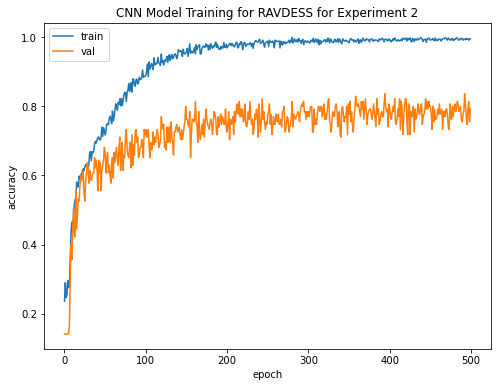

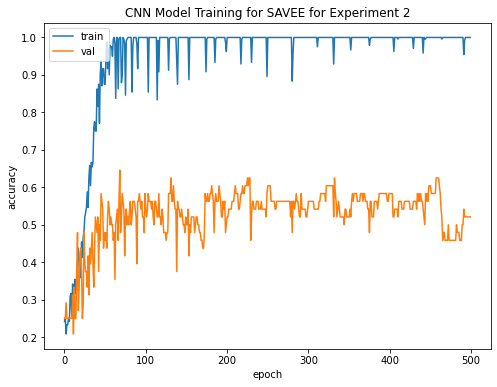

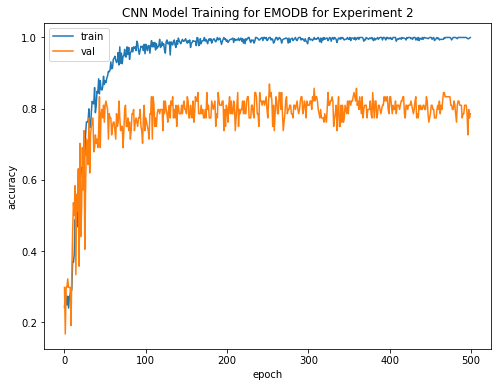

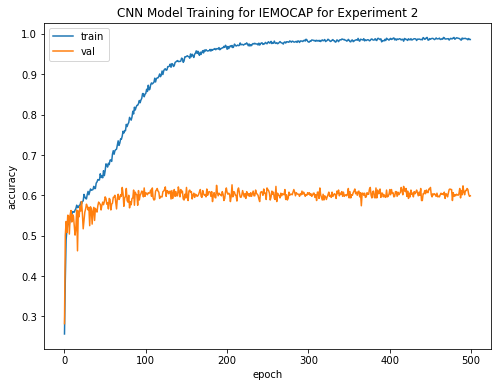

In [34]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

for dataset in  np.flip(sources):
    plt.figure(figsize=(8,6))
    acc = np.round(max(model_history[dataset]['val_sparse_categorical_accuracy']),2)
    # summarize history for accuracy
    plt.plot(model_history[dataset]['sparse_categorical_accuracy'])
    plt.plot(model_history[dataset]['val_sparse_categorical_accuracy'])
    plt.title(f'CNN Model Training for {dataset} for Experiment 1')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [1]:
print("Best Validation accuracy\n")
for dataset in  np.flip(sources):
    
    print(dataset, max(model_history[dataset]['val_sparse_categorical_accuracy']))

Best Validation accuracy

RAVDESS 0.837037
SAVEE 0.6458333
EMODB 0.86904764
IEMOCAP 0.625974


## Pre Trained and CNN Model comparison

<Figure size 576x432 with 0 Axes>

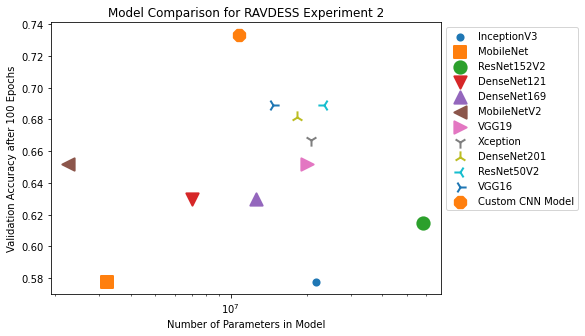

<Figure size 576x432 with 0 Axes>

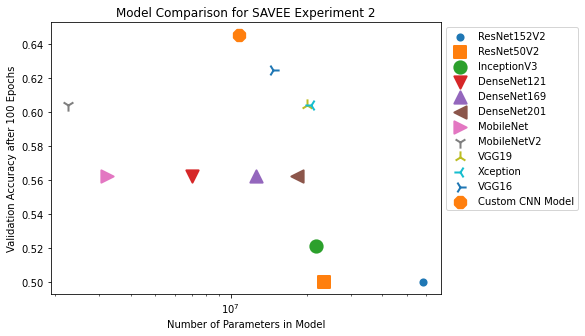

<Figure size 576x432 with 0 Axes>

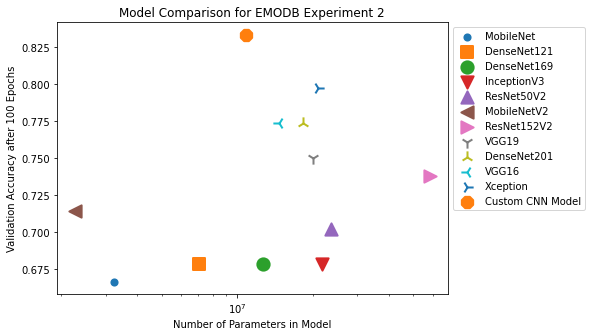

<Figure size 576x432 with 0 Axes>

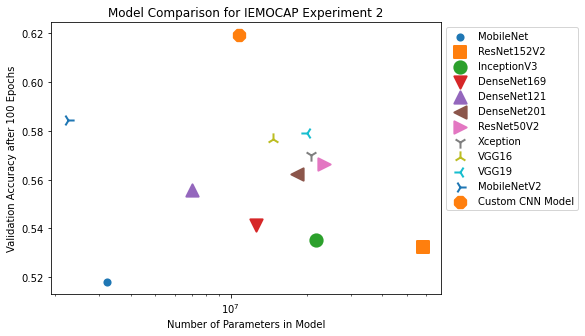

In [36]:
for dataset in  np.flip(sources):
    
    print(dataset, max(model_history[dataset]['val_sparse_categorical_accuracy']))
    max_test_accuracy= max(model_history[dataset]['val_sparse_categorical_accuracy'][:100])
    benchmark_df = model_benchmarks_map[dataset]
    benchmark_df.loc[len(benchmark_df.index)] = ['Custom CNN Model', 10800580,max_test_accuracy] 
    plt.figure(figsize=(8,6))
    # Loop over each row and plot the num_model_params vs validation_accuracy
    markers=[".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",4,5,6,7,8,9,10,11]
    plt.figure(figsize=(7,5))
    for row in benchmark_df.itertuples():
        plt.scatter(row.num_model_params, row.validation_accuracy, label=row.model_name, marker=markers[row.Index], s=150, linewidths=2)
    plt.xscale('log')
    plt.xlabel('Number of Parameters in Model')
    plt.ylabel('Validation Accuracy after 100 Epochs')
    plt.title(f'Model Comparison for {dataset} Experiment 1')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left'); # Move legend out of the plot
    model_benchmarks_map[dataset] = benchmark_df


In [28]:
print(sources[0])
benchmark_df= model_benchmarks_map[sources[0]]
benchmark_df.sort_values(by="validation_accuracy").reset_index(drop=True)

IEMOCAP


,model_name,num_model_params,validation_accuracy
0,MobileNet,3228864,0.518182
1,ResNet152V2,58331648,0.532468
2,InceptionV3,21802784,0.535065
3,DenseNet169,12642880,0.541558
4,DenseNet121,7037504,0.555844
5,DenseNet201,18321984,0.562338
6,ResNet50V2,23564800,0.566234
7,Xception,20861480,0.570130
8,VGG16,14714688,0.576623
9,VGG19,20024384,0.579221


In [29]:
print(sources[1])
benchmark_df= model_benchmarks_map[sources[1]]
benchmark_df.sort_values(by="validation_accuracy").reset_index(drop=True)

EMODB


,model_name,num_model_params,validation_accuracy
0,MobileNet,3228864,0.666667
1,DenseNet121,7037504,0.678571
2,DenseNet169,12642880,0.678571
3,InceptionV3,21802784,0.678571
4,ResNet50V2,23564800,0.702381
5,MobileNetV2,2257984,0.714286
6,ResNet152V2,58331648,0.738095
7,VGG19,20024384,0.750000
8,DenseNet201,18321984,0.773810
9,VGG16,14714688,0.773810


In [37]:
print(sources[2])
benchmark_df= model_benchmarks_map[sources[2]]
benchmark_df.sort_values(by="validation_accuracy").reset_index(drop=True)

SAVEE


,model_name,num_model_params,validation_accuracy
0,ResNet152V2,58331648,0.500000
1,ResNet50V2,23564800,0.500000
2,InceptionV3,21802784,0.520833
3,DenseNet121,7037504,0.562500
4,DenseNet169,12642880,0.562500
5,DenseNet201,18321984,0.562500
6,MobileNet,3228864,0.562500
7,MobileNetV2,2257984,0.604167
8,VGG19,20024384,0.604167
9,Xception,20861480,0.604167


In [31]:
print(sources[3])
benchmark_df= model_benchmarks_map[sources[3]]
benchmark_df.sort_values(by="validation_accuracy").reset_index(drop=True)

RAVDESS


,model_name,num_model_params,validation_accuracy
0,InceptionV3,21802784,0.577778
1,MobileNet,3228864,0.577778
2,ResNet152V2,58331648,0.614815
3,DenseNet121,7037504,0.629630
4,DenseNet169,12642880,0.629630
5,MobileNetV2,2257984,0.651852
6,VGG19,20024384,0.651852
7,Xception,20861480,0.666667
8,DenseNet201,18321984,0.681481
9,ResNet50V2,23564800,0.688889


## Performance Metrics

In [38]:
from sklearn.metrics import auc,roc_curve
def _check_pos_label_consistency(pos_label, y_true):
    """Check if `pos_label` need to be specified or not.
    In binary classification, we fix `pos_label=1` if the labels are in the set
    {-1, 1} or {0, 1}. Otherwise, we raise an error asking to specify the
    `pos_label` parameters.
    Parameters
    ----------
    pos_label : int, str or None
        The positive label.
    y_true : ndarray of shape (n_samples,)
        The target vector.
    Returns
    -------
    pos_label : int
        If `pos_label` can be inferred, it will be returned.
    Raises
    ------
    ValueError
        In the case that `y_true` does not have label in {-1, 1} or {0, 1},
        it will raise a `ValueError`.
    """
    # ensure binary classification if pos_label is not specified
    # classes.dtype.kind in ('O', 'U', 'S') is required to avoid
    # triggering a FutureWarning by calling np.array_equal(a, b)
    # when elements in the two arrays are not comparable.
    classes = np.unique(y_true)
    if pos_label is None and (
        classes.dtype.kind in "OUS"
        or not (
            np.array_equal(classes, [0, 1])
            or np.array_equal(classes, [-1, 1])
            or np.array_equal(classes, [0])
            or np.array_equal(classes, [-1])
            or np.array_equal(classes, [1])
        )
    ):
        classes_repr = ", ".join(repr(c) for c in classes)
        raise ValueError(
            f"y_true takes value in {{{classes_repr}}} and pos_label is not "
            "specified: either make y_true take value in {0, 1} or "
            "{-1, 1} or pass pos_label explicitly."
        )
    elif pos_label is None:
        pos_label = 1

    return pos_label

class RocCurveDisplay:
   

    def __init__(self, *, fpr, tpr, roc_auc=None, estimator_name=None, pos_label=None):
        self.estimator_name = estimator_name
        self.fpr = fpr
        self.tpr = tpr
        self.roc_auc = roc_auc
        self.pos_label = pos_label

    def plot(self, ax=None, *, name=None, **kwargs):
        """Plot visualization.

        Extra keyword arguments will be passed to matplotlib's ``plot``.

        Parameters
        ----------
        ax : matplotlib axes, default=None
            Axes object to plot on. If `None`, a new figure and axes is
            created.

        name : str, default=None
            Name of ROC Curve for labeling. If `None`, use `estimator_name` if
            not `None`, otherwise no labeling is shown.

        **kwargs : dict
            Keyword arguments to be passed to matplotlib's `plot`.

        Returns
        -------
        display : :class:`~sklearn.metrics.plot.RocCurveDisplay`
            Object that stores computed values.
        """
        name = self.estimator_name if name is None else name

        line_kwargs = {}
        if self.roc_auc is not None and name is not None:
            line_kwargs["label"] = f"{name} (AUC = {self.roc_auc:0.2f})"
        elif self.roc_auc is not None:
            line_kwargs["label"] = f"AUC = {self.roc_auc:0.2f}"
        elif name is not None:
            line_kwargs["label"] = name

        line_kwargs.update(**kwargs)

        import matplotlib.pyplot as plt

        if ax is None:
            fig, ax = plt.subplots()

        (self.line_,) = ax.plot(self.fpr, self.tpr, **line_kwargs)
        info_pos_label = (
            f" (Positive label: {self.pos_label})" if self.pos_label is not None else ""
        )

        xlabel = "False Positive Rate" + info_pos_label
        ylabel = "True Positive Rate" + info_pos_label
        ax.set(xlabel=xlabel, ylabel=ylabel)

        if "label" in line_kwargs:
            ax.legend(loc="lower right")

        self.ax_ = ax
        self.figure_ = ax.figure
        return self


    @classmethod
    def from_predictions(
        cls,
        y_true,
        y_pred,
        *,
        sample_weight=None,
        drop_intermediate=True,
        pos_label=None,
        name=None,
        ax=None,
        **kwargs,
    ):
        """Plot ROC curve given the true and predicted values.

        Read more in the :ref:`User Guide <visualizations>`.

        .. versionadded:: 1.0

        Parameters
        ----------
        y_true : array-like of shape (n_samples,)
            True labels.

        y_pred : array-like of shape (n_samples,)
            Target scores, can either be probability estimates of the positive
            class, confidence values, or non-thresholded measure of decisions
            (as returned by “decision_function” on some classifiers).

        sample_weight : array-like of shape (n_samples,), default=None
            Sample weights.

        drop_intermediate : bool, default=True
            Whether to drop some suboptimal thresholds which would not appear
            on a plotted ROC curve. This is useful in order to create lighter
            ROC curves.

        pos_label : str or int, default=None
            The label of the positive class. When `pos_label=None`, if `y_true`
            is in {-1, 1} or {0, 1}, `pos_label` is set to 1, otherwise an
            error will be raised.

        name : str, default=None
            Name of ROC curve for labeling. If `None`, name will be set to
            `"Classifier"`.

        ax : matplotlib axes, default=None
            Axes object to plot on. If `None`, a new figure and axes is
            created.

        **kwargs : dict
            Additional keywords arguments passed to matplotlib `plot` function.

        Returns
        -------
        display : :class:`~sklearn.metrics.RocCurveDisplay`
            Object that stores computed values.

        See Also
        --------
        roc_curve : Compute Receiver operating characteristic (ROC) curve.
        RocCurveDisplay.from_estimator : ROC Curve visualization given an
            estimator and some data.
        roc_auc_score : Compute the area under the ROC curve.

        Examples
        --------
        >>> import matplotlib.pyplot as plt
        >>> from sklearn.datasets import make_classification
        >>> from sklearn.metrics import RocCurveDisplay
        >>> from sklearn.model_selection import train_test_split
        >>> from sklearn.svm import SVC
        >>> X, y = make_classification(random_state=0)
        >>> X_train, X_test, y_train, y_test = train_test_split(
        ...     X, y, random_state=0)
        >>> clf = SVC(random_state=0).fit(X_train, y_train)
        >>> y_pred = clf.decision_function(X_test)
        >>> RocCurveDisplay.from_predictions(
        ...    y_test, y_pred)
        <...>
        >>> plt.show()
        """
     
        fpr, tpr, _ = roc_curve(
            y_true,
            y_pred,
            pos_label=pos_label,
            sample_weight=sample_weight,
            drop_intermediate=drop_intermediate,
        )
        roc_auc = auc(fpr, tpr)

        name = "Classifier" if name is None else name
        pos_label = _check_pos_label_consistency(pos_label, y_true)

        viz = RocCurveDisplay(
            fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name, pos_label=pos_label
        )

        return viz.plot(ax=ax, name=name, **kwargs)

import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc ,roc_auc_score
import matplotlib.pyplot as plt

from itertools import cycle

from sklearn import metrics
import itertools

def plot_metrics(dataset,model):

    print(dataset)
    X_train,y_train,X_test,y_test = get_train_test_data(source_data, dataset)
    
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob,axis=1)

    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)
    y_onehot_test.shape  # (n_samples, n_classes)
    y_score = label_binarizer.transform(y_pred)


    # store the fpr, tpr, and roc_auc for all averaging strategies
    fpr, tpr, roc_auc = dict(), dict(), dict()
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

    macro_roc_auc_ovr = roc_auc_score(
        y_test,
        y_score,
        multi_class="ovr",
        average="macro",
    )

    print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")

    n_classes =4
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr_grid = np.linspace(0.0, 1.0, 1000)

    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)

    for i in range(n_classes):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

    # Average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")



    target_names=['angry','happy','neutral', 'sad' ]

    fig, ax = plt.subplots(figsize=(8, 8))

    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue","green"])
    for class_id, color in zip(range(n_classes), colors):
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"ROC curve for {target_names[class_id]}",
            color=color,
            ax=ax,
        )

    plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
    plt.legend()
    plt.show()


    #importing accuracy_score, precision_score, recall_score, f1_score
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

    print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
    print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
    print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

    print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
    print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
    print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

    print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
    print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
    print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))



    score = metrics.accuracy_score(y_test, y_pred)
    print("accuracy:   %0.3f" % score)

    cm = metrics.confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    plot_confusion_matrix(cm, classes=['angry','happy','neutral', 'sad' ])

IEMOCAP
[2023-03-08 04:54:43.515 ip-172-16-17-2:16952 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-03-08 04:54:43.631 ip-172-16-17-2:16952 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Micro-averaged One-vs-Rest ROC AUC score:
0.94
Macro-averaged One-vs-Rest ROC AUC score:
0.94
Macro-averaged One-vs-Rest ROC AUC score:
0.94


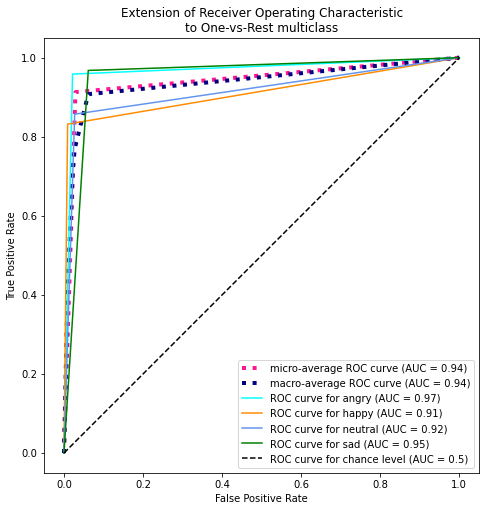


Accuracy: 0.91

Micro Precision: 0.91
Micro Recall: 0.91
Micro F1-score: 0.91

Macro Precision: 0.92
Macro Recall: 0.90
Macro F1-score: 0.91

Weighted Precision: 0.92
Weighted Recall: 0.91
Weighted F1-score: 0.91
accuracy:   0.913
Normalized confusion matrix


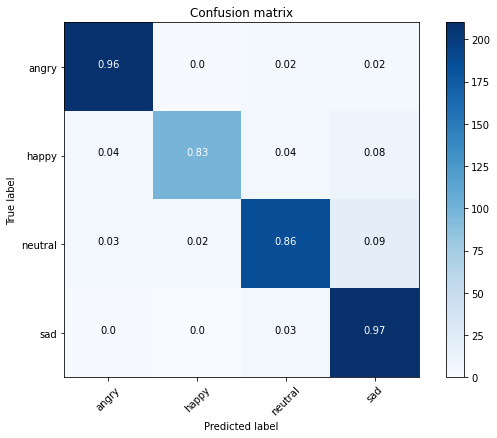

In [33]:
model = tf.keras.models.load_model("models/IEMOCAP_custom_cnn")
plot_metrics('IEMOCAP',model)

EMODB
Micro-averaged One-vs-Rest ROC AUC score:
0.98
Macro-averaged One-vs-Rest ROC AUC score:
0.97
Macro-averaged One-vs-Rest ROC AUC score:
0.97


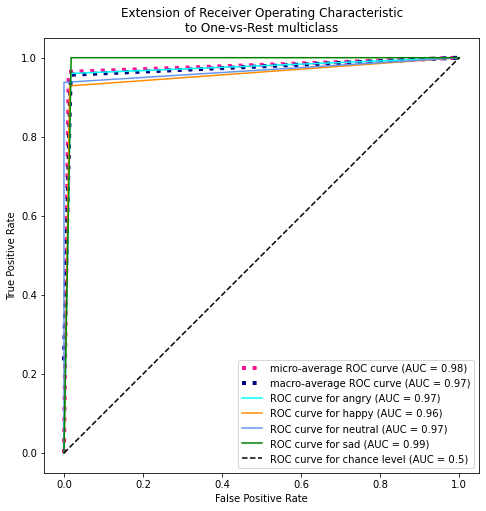


Accuracy: 0.96

Micro Precision: 0.96
Micro Recall: 0.96
Micro F1-score: 0.96

Macro Precision: 0.96
Macro Recall: 0.96
Macro F1-score: 0.96

Weighted Precision: 0.96
Weighted Recall: 0.96
Weighted F1-score: 0.96
accuracy:   0.964
Normalized confusion matrix


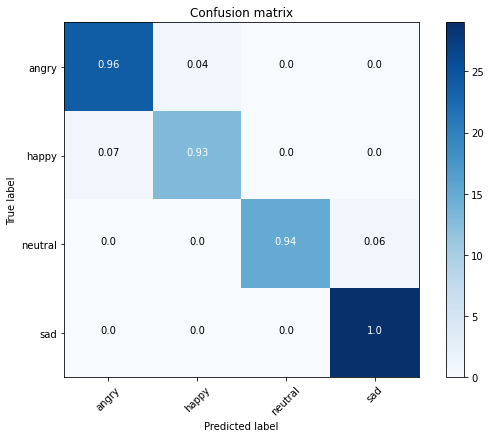

In [34]:
model = tf.keras.models.load_model("models/EMODB_custom_cnn")
plot_metrics('EMODB',model)

SAVEE
Micro-averaged One-vs-Rest ROC AUC score:
0.90
Macro-averaged One-vs-Rest ROC AUC score:
0.90
Macro-averaged One-vs-Rest ROC AUC score:
0.90


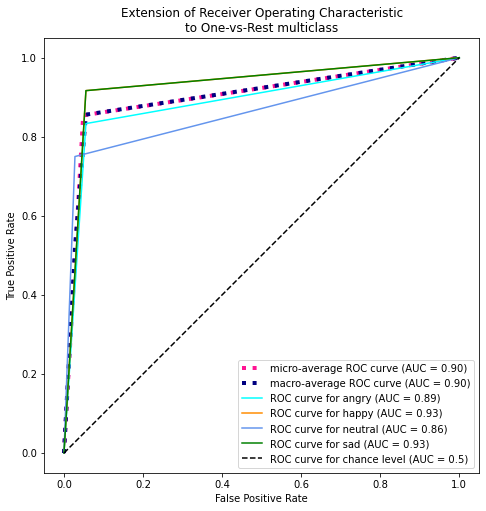


Accuracy: 0.85

Micro Precision: 0.85
Micro Recall: 0.85
Micro F1-score: 0.85

Macro Precision: 0.86
Macro Recall: 0.85
Macro F1-score: 0.85

Weighted Precision: 0.86
Weighted Recall: 0.85
Weighted F1-score: 0.85
accuracy:   0.854
Normalized confusion matrix


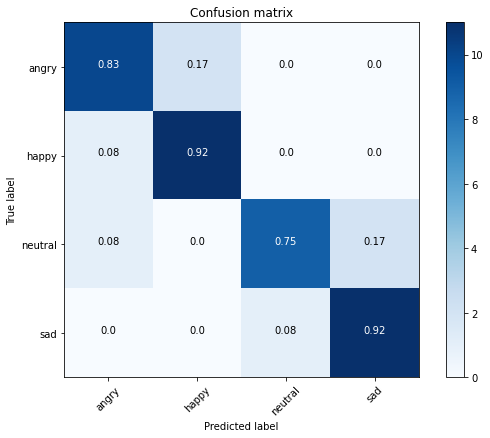

In [39]:
model = tf.keras.models.load_model("models/SAVEE_custom_cnn")
plot_metrics('SAVEE',model)

RAVDESS
Micro-averaged One-vs-Rest ROC AUC score:
0.97
Macro-averaged One-vs-Rest ROC AUC score:
0.96
Macro-averaged One-vs-Rest ROC AUC score:
0.96


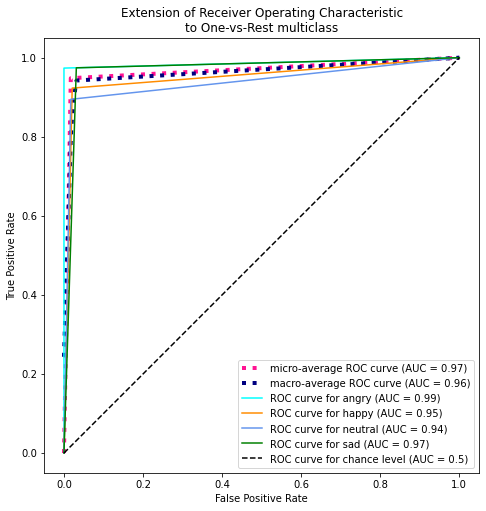


Accuracy: 0.95

Micro Precision: 0.95
Micro Recall: 0.95
Micro F1-score: 0.95

Macro Precision: 0.94
Macro Recall: 0.94
Macro F1-score: 0.94

Weighted Precision: 0.95
Weighted Recall: 0.95
Weighted F1-score: 0.95
accuracy:   0.948
Normalized confusion matrix


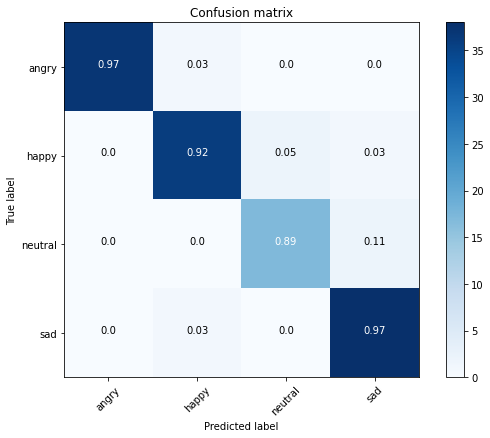

In [36]:
model = tf.keras.models.load_model("models/RAVDESS_custom_cnn")
plot_metrics('RAVDESS',model)